In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

## Algorithm 1 (features + labels private)

<img src="../image/alg1_2019.png" width="400" height="200">

In [2]:
def sample_dataset(n, p, c, k):
    x = np.random.randint(-1, 1, (n, p))
    noise = np.random.uniform(-c, c, n)
    
    theta_star = np.random.uniform(-1, 1, p)

    # make theta_star k-sparse randomly
    index = np.random.choice(range(p), k)
    for i in index:
        theta_star[i] = 0
        
    y = x @ theta_star + noise
    return x, y, theta_star

In [3]:
def experiment_setup(n, p):
    T = int(np.ceil(np.log2(n / p))) # number of iterations, rounded-up
    bucket_size = int(np.floor(n / T))
    theta_prev = np.zeros(p) # theta_zero

    index_set = [] # splitting into buckets
    for t in range(T):
        start = t * bucket_size
        end = (t + 1) * bucket_size - 1
        if t == T - 1:
            end = n - 1
            
        index_set.append((start, end))

    return T, theta_prev, index_set

In [4]:
def randomizer(x):
    return x

# TODO - implement randomizer

In [7]:
def run_experiment(n, p, k=3, eta=0.1, c=0.05, verbose=False):
    x, y, theta_star = sample_dataset(n, p, c, k)
    T, theta_prev, index_set = experiment_setup(n, p)
    
    for t in range(T):
        if verbose:
            print(f'\n============================== iteration {t} ==================================')
        
        all_gradients = []
        for i in range(index_set[t][0], index_set[t][1]):
            
            # user i computes their gradient locally
            # nabla_i = np.(np.transpose(x[i, :]), np.multiply(theta_prev, x[i, :]) - y[i])
            nabla_i = x[i].T * (x[i] @ theta_prev - y[i])
            
            # user i randomizes nabla i
            nabla_i = randomizer(nabla_i)
    
            all_gradients.append(nabla_i)

        if verbose:
            print("\nStep 1. ALL GRADIENTS")
            print(np.array(all_gradients).shape)
    
        # the "server" computes 
        # bucket_size = index_set[t][1] - index_set[t][0] + 1
        nabla_prev = np.array(all_gradients).sum(axis=0) / len(all_gradients)

        if verbose:
            print("\nLine 4. Aggregated gradient")
            print(np.array(nabla_prev).shape)
    
        # perform gradient descend
        theta_t = theta_prev - eta * nabla_prev
        if verbose:
            print("\nLine 5. Descent")
            print(theta_t)
    
        # truncation - make sparse
        # keep the k largest elements => make the smallest p - k elements zero
        argmin_k_indices = np.argpartition(theta_t, -(p - k))[:(p - k)] 
        for j in argmin_k_indices:
            theta_t[j] = 0

        if verbose:
            print("\nLine 6. Sparsity")   
            print(theta_t)

        theta_t = theta_t / LA.norm(theta_t, ord=2)
        if verbose:
            print("\nLine 7. Projection to ball")   
            print(theta_t)
        
        theta_prev = theta_t

    # compute error
    e = LA.norm(theta_t - theta_star, ord=2) / LA.norm(theta_star, ord=2)
    return e

In [8]:
# DEBUG
# run_experiment(100, 10, k=5, eta=0.2)

## Experiment 1 - varying dimensionality (p) - figure 1a

In [9]:
n_values = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
p_values = [16, 64, 128, 256]
k = 10
results = {}

In [10]:
for n in n_values:
    for p in p_values:
        min_error = 1.0
        for i in range(10):
            e = run_experiment(int(n * (10 ** 5)), p, k, eta=0.1, c=0.05, verbose=False)
            if e < min_error:
                min_error = e
            
        if not p in results:
            results[p] = []
        results[p].append(min_error)
        print(n, p, min_error)

1 16 0.23948388207389382
1 64 0.8933319693205868
1 128 0.9517354602064497
1 256 0.9764293428381015
1.5 16 0.48360887067220354
1.5 64 0.9508047050008784
1.5 128 0.9393331505627768
1.5 256 0.9720183272485444
2 16 0.5206286719541434
2 64 0.9135958824659464
2 128 0.9483644075113237
2 256 0.9844927900719466
2.5 16 0.557393625396651
2.5 64 0.8965994554516064
2.5 128 0.9457162330561962
2.5 256 0.9777488900394405
3 16 0.5490435385019573
3 64 0.9103833610490415
3 128 0.9758078323775807
3 256 0.9743416040543452
3.5 16 0.6072911835258732
3.5 64 0.8783015914500498
3.5 128 0.9576793160813915
3.5 256 0.9716075166517835
4 16 0.483975200908379
4 64 0.8757920478611182
4 128 0.9415477000806806
4 256 0.977345843112099
4.5 16 0.4879956819842366
4.5 64 0.901270858926927
4.5 128 0.9548480830362591
4.5 256 0.9829983245239683
5 16 0.6163342249100714
5 64 0.8901546571100499
5 128 0.9549154303778672
5 256 0.975712810643424


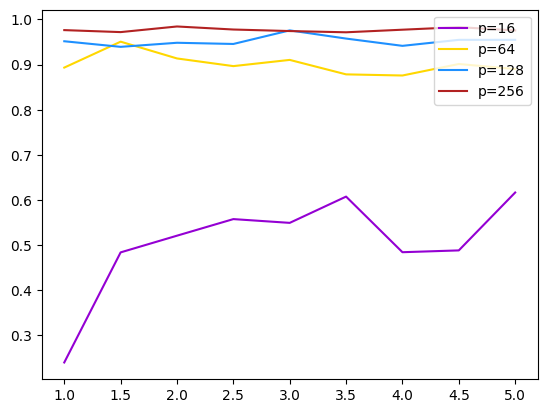

In [11]:
colors = ["darkviolet", "gold", "dodgerblue", "firebrick"]
for i in range(len(p_values)):
    p = p_values[i]
    plt.plot(n_values, results[p], label=f'p={p}', color=colors[i])

plt.legend(loc=1)
plt.show()

## Experiment 2 - varying sparsity level (k) - figure 1b

In [ ]:
n_values = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
k_values = [10, 20, 40, 100]
p = 64
results = {}

In [ ]:
for n in n_values:
    for k in k_values:
        min_error = 1.0
        for i in range(10):
            e = run_experiment(int(n * (10 ** 5)), p, k, eta=0.1, c=0.05, verbose=False)
            if e < min_error:
                min_error = e
            
        if not k in results:
            results[k] = []
        results[k].append(min_error)
        print(n, k, min_error)

In [ ]:
colors = ["darkviolet", "gold", "dodgerblue", "firebrick"]
for i in range(len(k_values)):
    k = k_values[i]
    plt.plot(n_values, results[k], label=f's={k}', color=colors[i])

plt.legend(loc=1)
plt.show()